# 인공 작사가 만들기

### 라이브러리 버전 확인

In [1]:
import glob # glob 함수 : 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 데이터 다운로드

In [2]:
!mkdir -p ~/aiffel/lyricist/models
!ln -s ~/data ~/aiffel/lyricist/data
# 이미 이전에 불러와서 failed가 떴다.

ln: failed to create symbolic link '/aiffel/aiffel/lyricist/data/data': Read-only file system


## Step 2. 데이터 읽어오기

In [3]:
import glob
import os, re
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path) # txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list에 할당

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() # splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) 
        
print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Busted flat in Baton Rouge, waitin' for a train", "And I's feelin' near as faded as my jeans", 'Bobby thumbed a diesel down, just before it rained']


## Step 3. 데이터 정제

In [4]:
# 필요없는 문장 지우기
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue # 길이가 0인 문장 건너뛰기
        
    if idx > 9 : break # 문장 10개만 확인
        
    print(sentence)

Busted flat in Baton Rouge, waitin' for a train
And I's feelin' near as faded as my jeans
Bobby thumbed a diesel down, just before it rained
It rode us all the way to New Orleans I pulled my harpoon out of my dirty red bandanna
I was playin' soft while Bobby sang the blues, yeah
Windshield wipers slappin' time, I was holdin' Bobby's hand in mine
We sang every song that driver knew Freedom's just another word for nothin' left to lose
Nothin', don't mean nothin' hon' if it ain't free, no no
And, feelin' good was easy, Lord, when he sang the blues
You know, feelin' good was good enough for me


In [5]:
# 문장 전처리
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자로 바꾸고, 양쪽 공백 지우기
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자 양쪽에 공백 넣기
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꾸기
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기
    sentence = sentence.strip() # 다시 양쪽 공백 지우기
    sentence = '<start> ' + sentence + ' <end>' # 문장 시작에는 <start> , 끝에는 <end>추가
    return sentence

In [8]:
sentence_split = preprocess_sentence(sentence).split()

- 공백 기준으로 분할하여 각 문장을 토큰화했을 때처럼 만들어주었다.

In [9]:
# 정제 데이터 구축하기
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    if len(sentence) == 0: continue # 길이가 0인 문장 제외
    if len(sentence_split) >= 17: continue # <start>, <end> 제외하고 토큰이 15개를 넘어가는 문장 제외
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주기
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

# 정제된 결과를 10개만 확인
print(corpus[:10])
len(corpus)

['<start> busted flat in baton rouge , waitin for a train <end>', '<start> and i s feelin near as faded as my jeans <end>', '<start> bobby thumbed a diesel down , just before it rained <end>', '<start> it rode us all the way to new orleans i pulled my harpoon out of my dirty red bandanna <end>', '<start> i was playin soft while bobby sang the blues , yeah <end>', '<start> windshield wipers slappin time , i was holdin bobby s hand in mine <end>', '<start> we sang every song that driver knew freedom s just another word for nothin left to lose <end>', '<start> nothin , don t mean nothin hon if it ain t free , no no <end>', '<start> and , feelin good was easy , lord , when he sang the blues <end>', '<start> you know , feelin good was good enough for me <end>']


175986

## Step 4. 평가 데이터셋 분리

In [10]:
# 15,000단어를 기억할 수 있는 tokenizer 만들기
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000,
        filters=' ', # 이미 문장을 정제했기 떄문에 filters는 필요없음
        oov_token="" # <UNK> # 15000단어에 포함되지 못한 단어는 ""로 바꾸기
    )
    
    # corpus를 이용해 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰주기
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 3609 1692 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2  804 7664 ...    0    0    0]
 ...
 [   2    5   22 ...    0    0    0]
 [   2    5   22 ...    0    0    0]
 [   2    5   22 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f8a4fa25040>


- 텐서플로우의 Tokenizer와 pad_sequences를 사용해서 토큰화할 수 있다.
- tf.keras.preprocessing.text.Tokenizer 패키지 : 정제된 데이터를 토큰화하고, 단어 사전을 만들어주며, 데이터를 숫자로 변환(벡터화 vectorize)  
- tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드  
- tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드

In [11]:
# 3번째 행, 14번째 열까지만 출력
print(tensor[:3, :14])

[[   2 3609 1692   14 7058 3995    4 1100   28    9  681    3    0    0]
 [   2    8    5   16  513  848   81 2589   81   13  948    3    0    0]
 [   2  804 7664    9 6048   60    4   36  185   11 4575    3    0    0]]


- 텐서 데이터는 모두 정수로 이루어져 있으며, 이 숫자는 tokenizer에 구축된 단어 사전의 인덱스이다.

In [12]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형태로 반환
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : 
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [14]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성하기
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2 3609 1692   14 7058 3995    4 1100   28    9  681    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [15]:
import sklearn
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=20)

print(enc_train.shape, dec_train.shape)
print(enc_val.shape, dec_val.shape)

(140788, 346) (140788, 346)
(35198, 346) (35198, 346)


In [16]:
# 데이터셋 객체를 생성
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 15000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 346), (256, 346)), types: (tf.int32, tf.int32)>

## Step 5. 인공지능 만들기

In [17]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # 1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져온다.  
embedding_size = 128 # 워드 벡터의 차원수, 단어가 추상적으로 표현되는 크기
hidden_size = 128 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

- 입력 텐서에 들어 있는 단어 사전의 인덱스 -> Embedding 레이어 : 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔주기 -> 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용  
- embedding_size = 2048, hidden_size = 2048로 설정했을 때, 한 배치만 불러온 데이터를 모델에 넣어봤을 때, 크기가 너무 큰 나머지 resourceexhaustederror가 발생했다.  
그래서 embedding_size = 1024, hidden_size = 1024로 설정했을 때, 한 배치만 불러온 데이터를 모델에 넣어봤을 때, 다시 resourceexhaustederror가 발생했다. 여전히 크기가 너무 컸던 거 같다.   
embedding_size = 256, hidden_size = 1024로 설정했을 때에도 계속해서 같은 에러가 발생했고, 처음부터 다시 셀을 돌려보기로 했다. 그러면서 

In [18]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법(model에 데이터를 아주 조금 넣어보는 것)
# model의 input shape이 결정되면서 model.build()가 자동으로 호출됨.
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어보기
model(src_sample)

<tf.Tensor: shape=(256, 346, 15001), dtype=float32, numpy=
array([[[ 1.20692406e-04,  6.11458381e-05,  5.36778170e-05, ...,
         -2.62293561e-05, -2.12236555e-05,  4.41464108e-05],
        [ 2.42754060e-04, -6.46849958e-06, -5.72653989e-05, ...,
          3.90439855e-05, -6.51099690e-05, -6.69616929e-05],
        [ 2.50645564e-04, -1.13424539e-04,  5.03541014e-06, ...,
         -4.30872342e-06, -1.41379460e-05, -2.62799120e-04],
        ...,
        [-4.95947374e-04,  2.86488576e-05, -2.33744713e-03, ...,
         -1.77308882e-03, -2.15978059e-03,  2.06259172e-03],
        [-4.95947374e-04,  2.86488576e-05, -2.33744713e-03, ...,
         -1.77308882e-03, -2.15978059e-03,  2.06259172e-03],
        [-4.95947374e-04,  2.86488576e-05, -2.33744713e-03, ...,
         -1.77308882e-03, -2.15978059e-03,  2.06259172e-03]],

       [[ 1.20692406e-04,  6.11458381e-05,  5.36778170e-05, ...,
         -2.62293561e-05, -2.12236555e-05,  4.41464108e-05],
        [ 8.09638877e-05,  2.15759152e-04,  

In [19]:
# 모델의 구조를 확인
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1920128   
_________________________________________________________________
lstm (LSTM)                  multiple                  131584    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  131584    
_________________________________________________________________
dense (Dense)                multiple                  1935129   
Total params: 4,118,425
Trainable params: 4,118,425
Non-trainable params: 0
_________________________________________________________________


In [20]:
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수
    from_logits=True, # 기본값은 False. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다.(softmax함수가 적용되지 않았다는걸 의미) 
    reduction='none'  # 기본값은 SUM. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정
hist = model.fit(dataset, epochs=10, validation_data=(enc_val, dec_val)) # 만들어둔 데이터셋으로 모델을 학습.(10번 학습을 반복)

Epoch 1/10
687/687 [==============================] - 555s 801ms/step - loss: 0.4775 - val_loss: 0.1599
Epoch 2/10
687/687 [==============================] - 553s 804ms/step - loss: 0.1541 - val_loss: 0.1493
Epoch 3/10
687/687 [==============================] - 553s 805ms/step - loss: 0.1470 - val_loss: 0.1436
Epoch 4/10
687/687 [==============================] - 555s 807ms/step - loss: 0.1420 - val_loss: 0.1395
Epoch 5/10
687/687 [==============================] - 556s 808ms/step - loss: 0.1383 - val_loss: 0.1360
Epoch 6/10
687/687 [==============================] - 556s 809ms/step - loss: 0.1352 - val_loss: 0.1330
Epoch 7/10
687/687 [==============================] - 556s 809ms/step - loss: 0.1324 - val_loss: 0.1303
Epoch 8/10
687/687 [==============================] - 557s 811ms/step - loss: 0.1298 - val_loss: 0.1277
Epoch 9/10
687/687 [==============================] - 559s 813ms/step - loss: 0.1274 - val_loss: 0.1253
Epoch 10/10
687/687 [==============================] - 561s 816m

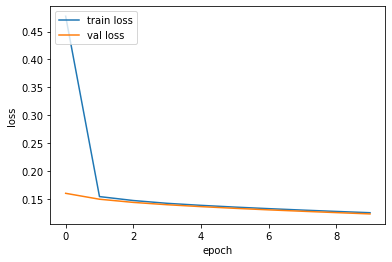

In [21]:
# 학습결과 시각화
import matplotlib.pyplot as plt
%matplotlib inline

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], label = 'train loss')
loss_ax.plot(hist.history['val_loss'], label = 'val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

In [22]:
# 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하는 함수만들기
def generate_text(model, tokenizer, init_sentence="", max_len=20):  
    test_input = tokenizer.texts_to_sequences([init_sentence]) # init_sentence 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64) # 텐서로 변환
    end_token = tokenizer.word_index[""]

    # 단어 하나씩 예측해 문장 만들기(루프를 돌면서 init_sentence에 단어를 하나씩 생성)
    while True:
        predict = model(test_tensor) # 입력받은 문장의 텐서 입력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] # 예측된 값 중 가장 높은 확률인 word index 뽑아내기
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1) # 예측된 word index를 문장 뒤에 붙이기
        if predict_word.numpy()[0] == end_token: break # 모델이 를 예측했거나
        if test_tensor.shape[1] >= max_len: break # max_len에 도달했다면 문장 생성을 마침
            
    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [24]:
generate_text(model, tokenizer, init_sentence="i love", max_len=20)
# generate_text 함수에 model이라 정의한 모델을 이용해서 i love 로 시작되는 문장을 생성

'i love t t meenie meenie meenie meenie meenie meenie meenie meenie meenie meenie meenie meenie meenie meenie meenie meenie '

## Reference
[문장분할](https://rfriend.tistory.com/748)  